In [14]:
import networkx as nx
import numpy as np

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.data.process.data_synthesis as synthesis
import matching.misc.cpg_const as cpg_const

In [15]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "CPG_augm_large"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

args = arg_utils.load_args( args, model_name )
args.iso = True
args.test_data = True

In [16]:
config_file = f"{args.config_dir}{args.dataset}.json"
config = synthesis.read_config( config_file )
config

{'number_source': 4880,
 'avg_source_size': 17.286065573770493,
 'std_source_size': 11.022895811050464,
 'avg_degree': 1.9471223120035026,
 'std_degree': 0.4405550933706308,
 'number_label_node': 5,
 'number_label_edge': 1,
 'number_subgraph_per_source': 512}

In [17]:
def add_features( graph, NN, NE, strict_edges=False ):
    # add anchor by pagerank score
    anchor = graph_utils.top_pr_ranked_node( graph )
    for _, data in graph.nodes( data=True ):
        data[ "anchor" ] = 0
    graph.nodes[ anchor ][ "anchor" ] = 1

    # add node labels
    bft_tree = nx.traversal.dfs_tree( nx.Graph( graph ), anchor )
    even_depth_label = misc_utils.get_enum_idx( cpg_const.NodeLabel.RECORD )
    odd_depth_labels = [ i for i in list( range( 1, NN + 1 ) ) if i != even_depth_label ]
    stack = [ (anchor, 0) ]
    while stack:
        current_node, depth = stack.pop()
        if depth % 2 == 0:
            graph.nodes[ current_node ][ "label" ] = even_depth_label
        else:
            graph.nodes[ current_node ][ "label" ] = np.random.choice( odd_depth_labels )
        for child in bft_tree.successors( current_node ):
            stack.append( (child, depth + 1) )

    # add edge labels and optionally remove invalid edges 
    edges_to_remove = list()
    for source_nid, target_nid, edata in graph.edges( data=True ):

        source_label = graph.nodes[ source_nid ][ "label" ]
        target_label = graph.nodes[ target_nid ][ "label" ]

        if source_label == even_depth_label and target_label == even_depth_label:
            edges_to_remove.append( (source_nid, target_nid) )
            continue
        if source_label in odd_depth_labels and target_label in odd_depth_labels:
            edges_to_remove.append( (source_nid, target_nid) )
            continue

        edata[ "label" ] = np.random.randint( 1, NE + 1, 1 )[ 0 ]
    if strict_edges:
        for source_nid, target_nid in edges_to_remove:
            graph.remove_edge( source_nid, target_nid )

    return graph, anchor

In [18]:
def generate_example( config, seed, strict_edges=False, normalize=False ):
    misc_utils.set_seed( seed )
    G = synthesis.generate_connected_graph(
        config[ "avg_source_size" ],
        config[ "std_source_size" ],
        config[ "avg_degree" ],
        config[ "std_degree" ],
        False
    )
    G, anchor = synthesis.add_features( G, 
                              config[ "number_label_node" ], 
                              config[ "number_label_edge" ],
                              strict_edges=strict_edges )
    if normalize:
        G, _ = graph_utils.normalize_graph( G, max_distance=4, force_directed=True )
    plot_utils.plot_graph( G,
                           title=f"Example #{seed}",
                           nodeColors=graph_utils.get_node_colors( G ),
                           nodeLabels=graph_utils.get_node_labels( G ) )

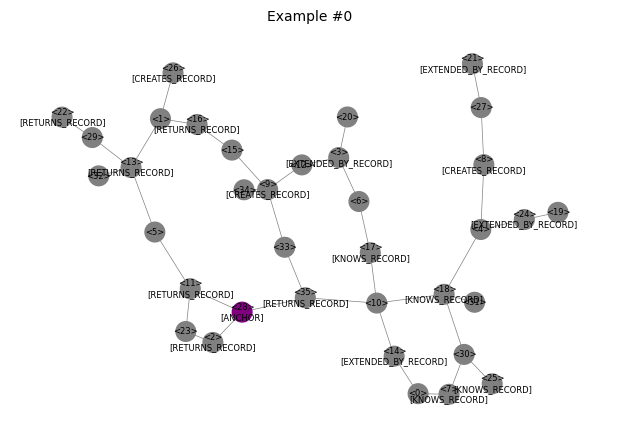

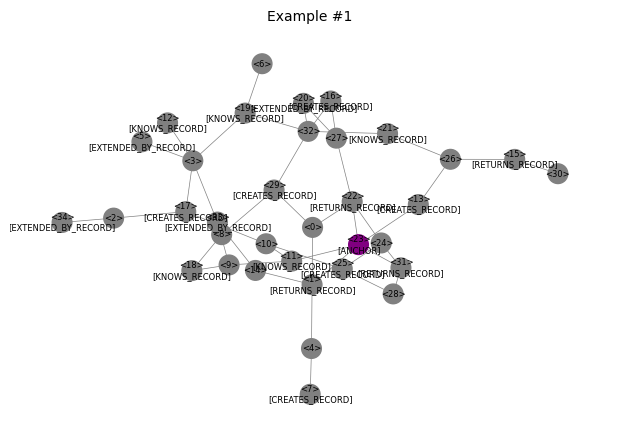

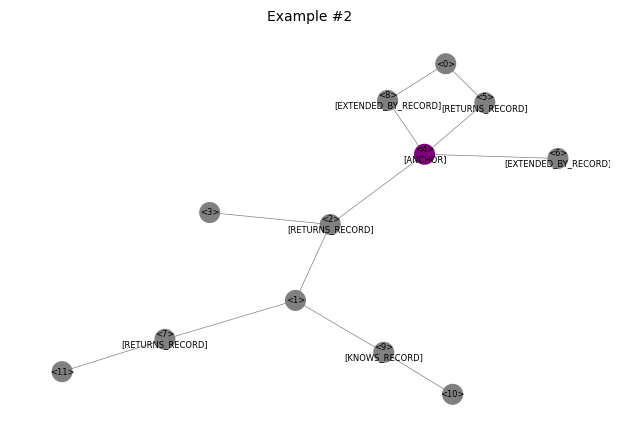

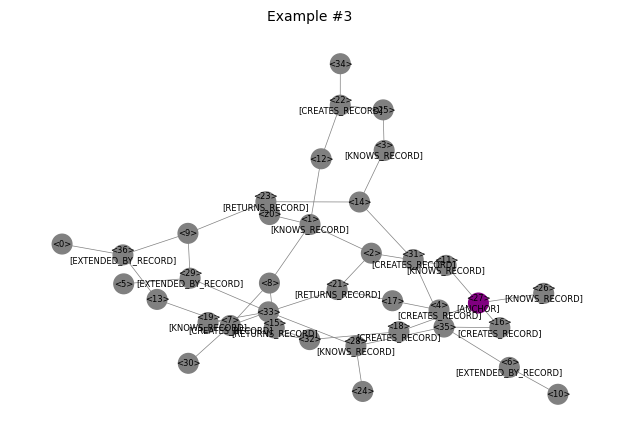

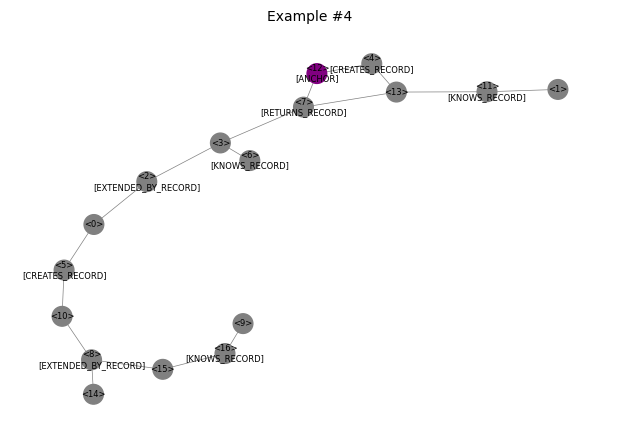

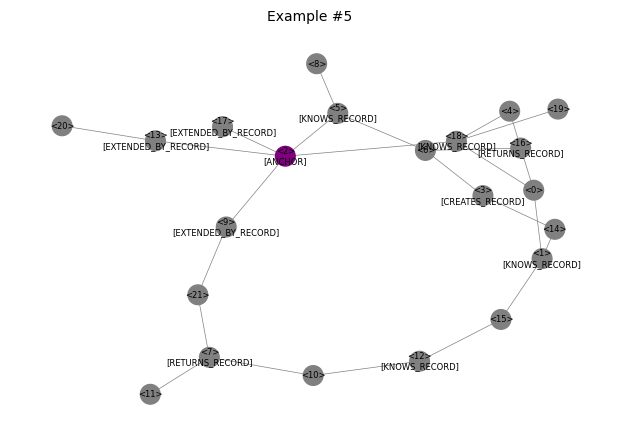

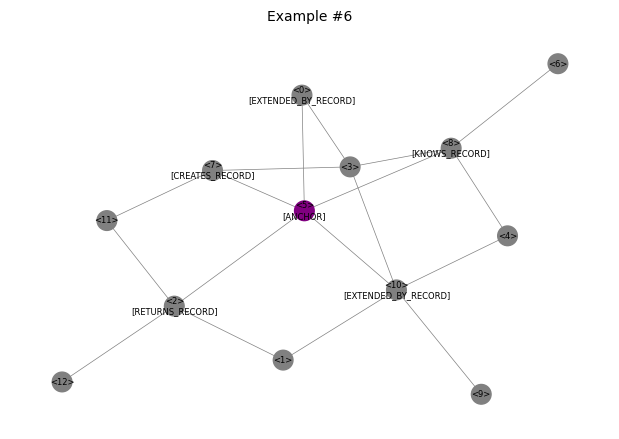

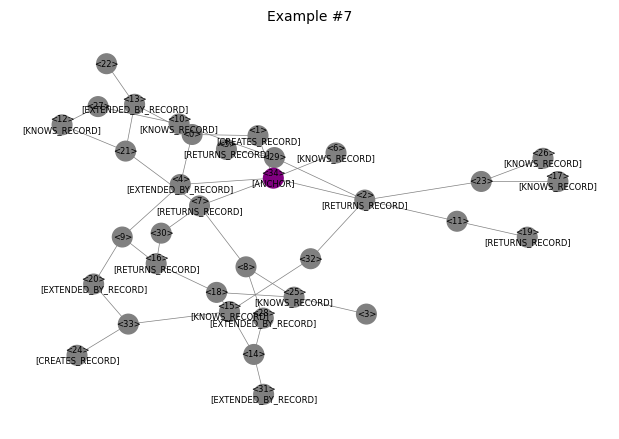

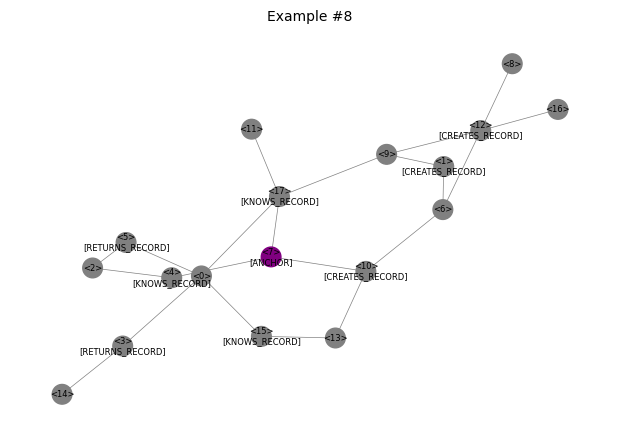

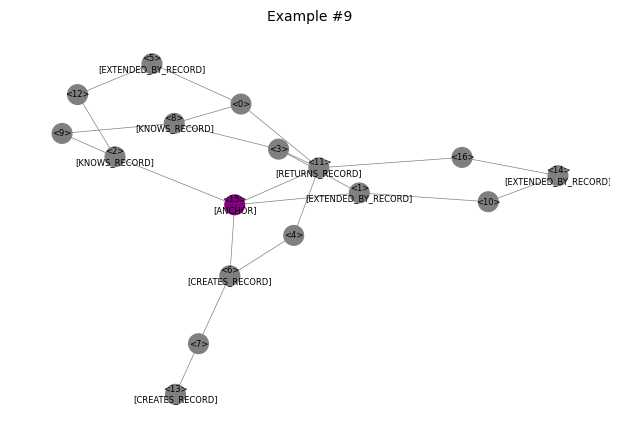

In [19]:
for i in list( range( 10 ) ):
    generate_example( config, i, strict_edges=True, normalize=False )